In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

from MlpTSMixer import MlpTSMixerEstimator

In [3]:
dataset = get_dataset("exchange_rate_nips", regenerate=False)
train_grouper = MultivariateGrouper(
    max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality)
)

test_grouper = MultivariateGrouper(
    num_test_dates=int(len(dataset.test) / len(dataset.train)),
    max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
)
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

In [4]:
estimator = MlpTSMixerEstimator(
    # distr_output=StudentTOutput(dim=int(dataset.metadata.feat_static_cat[0].cardinality)),
    input_size=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length * 2,
    freq=dataset.metadata.freq,
    scaling="std",
    patch_reverse_mapping_layer="mlp",
    depth=3,
    patch_size=(4, 4),
    dim=32,
    expansion_factor=4,
    batch_size=64,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(accelerator="cuda", max_epochs=100),
)

In [5]:
predictor = estimator.train(
    training_data=dataset_train,
    cache_data=True,
    shuffle_buffer_length=1024,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\maerzale\.virtualenvs\ConvTS_Mixer-3Rl3B8jo\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
C:\Users\maerzale\.virtualenvs\ConvTS_Mixer-3Rl3B8jo\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RAN

Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached -2.90998 (best -2.90998), saving model to 'C:\\Users\\maerzale\\OneDrive - adidas\\ConvTS Mixer\\lightning_logs\\version_7\\checkpoints\\epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached -3.20371 (best -3.20371), saving model to 'C:\\Users\\maerzale\\OneDrive - adidas\\ConvTS Mixer\\lightning_logs\\version_7\\checkpoints\\epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached -3.24658 (best -3.24658), saving model to 'C:\\Users\\maerzale\\OneDrive - adidas\\ConvTS Mixer\\lightning_logs\\version_7\\checkpoints\\epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached -3.28321 (best -3.28321), saving model to 'C:\\Users\\maerzale\\OneDrive - adidas\\ConvTS Mixer\\lightning_logs\\version_7\\checkpoints\\epoch=3-step=400.ckpt' as top 1
Epoch 4, global step 500: 'train_loss' reached -3.34360 (best -3.34360), saving model to 'C:\\Users\\maerzale\\OneDrive - adidas\\ConvTS

In [6]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset_test, predictor=predictor, num_samples=100
)
forecasts = list(forecast_it)
targets = list(ts_it)

In [7]:
evaluator = MultivariateEvaluator(
    quantiles=(np.arange(20) / 20.0)[1:], target_agg_funcs={"sum": np.sum}
)

In [8]:
agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 5it [00:00, 36.61it/s]
Running evaluation: 5it [00:00, 43.50it/s]
Running evaluation: 5it [00:00, 33.87it/s]
Running evaluation: 5it [00:00, 35.81it/s]
Running evaluation: 5it [00:00, 36.07it/s]
Running evaluation: 5it [00:00, 38.56it/s]
Running evaluation: 5it [00:00, 38.14it/s]
Running evaluation: 5it [00:00, 29.49it/s]
Running evaluation: 5it [00:00, 35.76it/s]


In [9]:
print("CRPS-Sum: {}".format(agg_metric["m_sum_mean_wQuantileLoss"]))
print("CRPS: {}".format(agg_metric["mean_wQuantileLoss"]))
print("QL50: {}".format(agg_metric["wQuantileLoss[0.5]"]))
print("QL90: {}".format(agg_metric["wQuantileLoss[0.9]"]))
print("MSIS: {}".format(agg_metric["MSIS"]))
print("NRMSE: {}".format(agg_metric["NRMSE"]))
print("sMAPE: {}".format(agg_metric["sMAPE"]))
print("MASE: {}".format(agg_metric["MASE"]))

# print("ND: {}".format(agg_metric["ND"]))
# print("NRMSE: {}".format(agg_metric["NRMSE"]))
# print("MSE: {}".format(agg_metric["MSE"]))

CRPS-Sum: 0.009728049617910009
CRPS: 0.011283578707981029
QL50: 0.01452657379068191
QL90: 0.006398246940332429
MSIS: 22.355173273168354
NRMSE: 0.026620223964443912
sMAPE: 0.018940066074331602
MASE: 2.482482153911337


In [10]:
print("CRPS: {}".format(agg_metric["mean_wQuantileLoss"]))
print("ND: {}".format(agg_metric["ND"]))
print("NRMSE: {}".format(agg_metric["NRMSE"]))
print("MSE: {}".format(agg_metric["MSE"]))

print("CRPS-SUM: {}".format(agg_metric["m_sum_mean_wQuantileLoss"]))

CRPS: 0.011283578707981029
ND: 0.014526573850799456
NRMSE: 0.026620223964443912
MSE: 0.00046874838006241747
CRPS-SUM: 0.009728049617910009


In [11]:
def plot(
    target,
    forecast,
    prediction_length,
    prediction_intervals=(50.0, 90.0),
    color="g",
    fname=None,
):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape

    ps = [50.0] + [
        50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
    ]

    percentiles_sorted = sorted(set(ps))

    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3

    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)

        ps_data = [forecast.quantile(p / 100.0)[:, dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2

        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)

        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]
    axx[0].legend(legend, loc="upper left")

    if fname is not None:
        plt.savefig(fname, bbox_inches="tight", pad_inches=0.05)

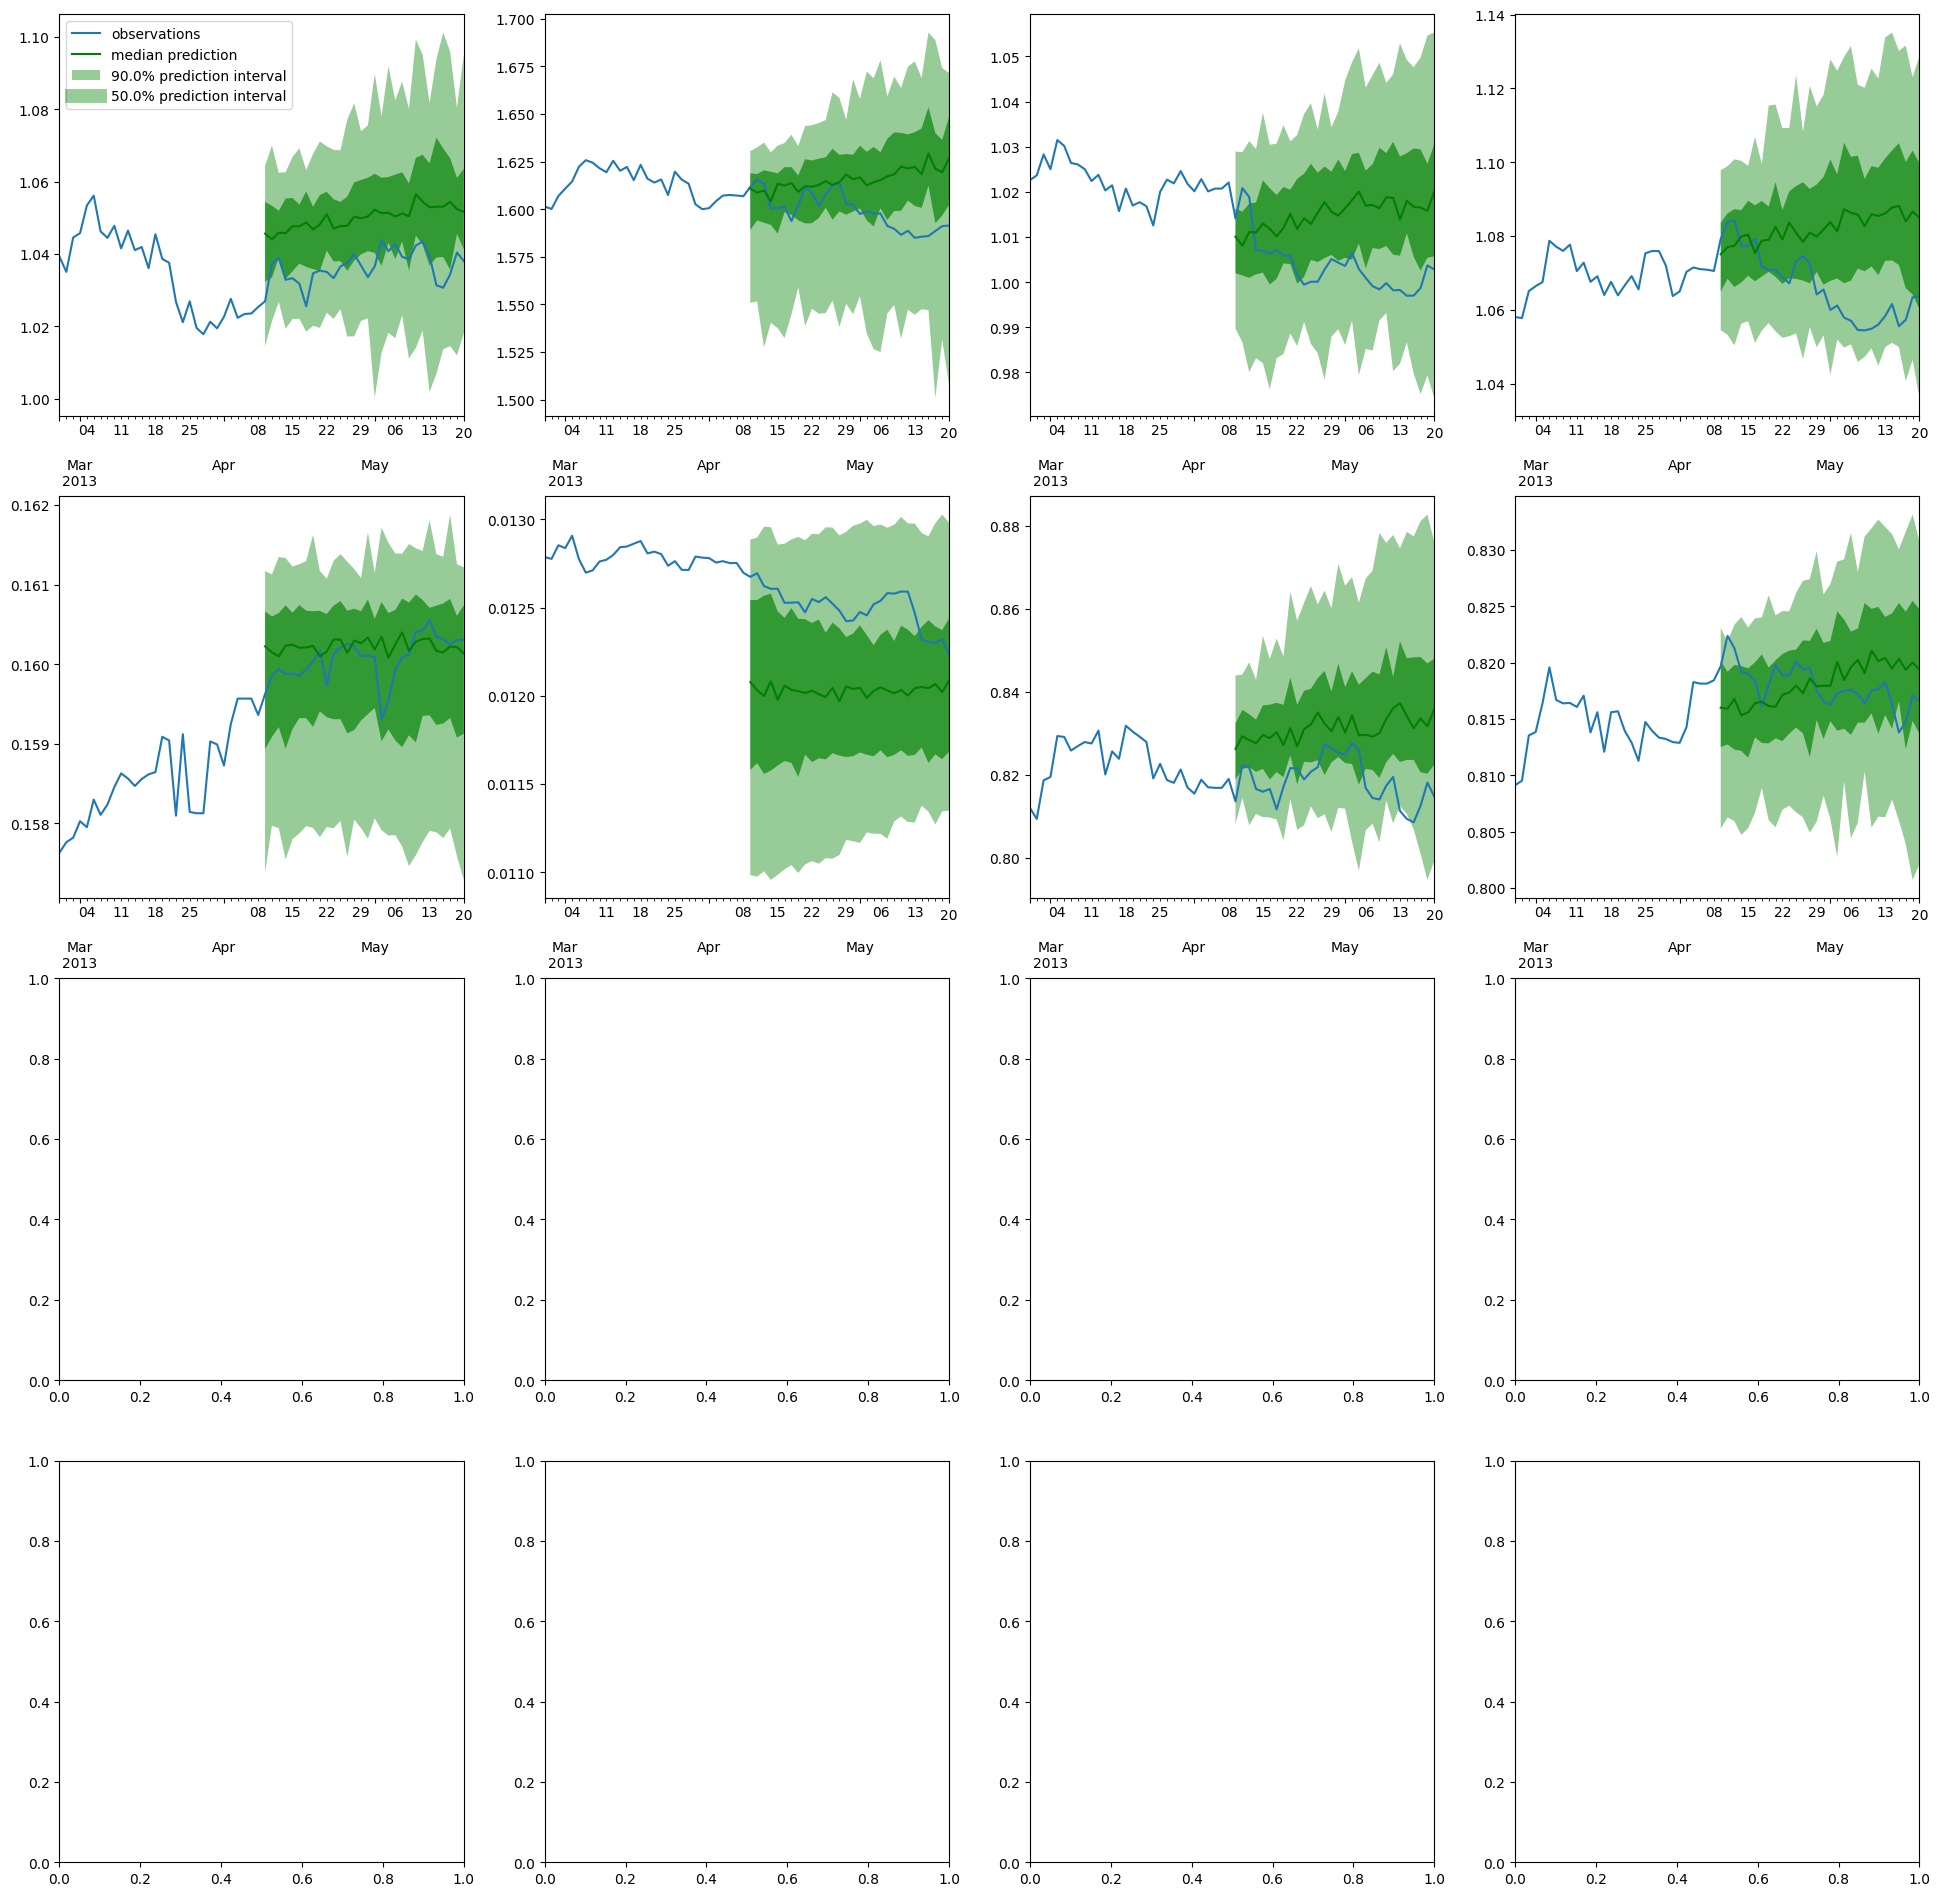

In [12]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()